# Employee Attendance and Productivity Analysis

Use facial recognition to track employee attendance and analyze productivity based on time spent at the workplace.

In [212]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

sns.set(style="whitegrid")


In [213]:
df = pd.read_csv('data/transformation/transformed_attendance/part-00000-7e13281b-23c8-40a3-8d08-2bc81e422947-c000.csv')
df.head()

,Name,session_id,first_in,last_out
0,ARKAJ POTDAR,0,2023-05-25T08:00:00.000-04:00,2023-05-25T08:04:00.000-04:00
1,ARKAJ POTDAR,1,2023-05-25T08:24:00.000-04:00,2023-05-25T08:28:00.000-04:00
2,ARKAJ POTDAR,2,2023-05-25T09:10:00.000-04:00,2023-05-25T09:37:00.000-04:00
3,ARKAJ POTDAR,3,2023-05-25T09:52:00.000-04:00,2023-05-25T10:20:00.000-04:00
4,ARKAJ POTDAR,4,2023-05-25T10:55:00.000-04:00,2023-05-25T11:00:00.000-04:00


## Data Pre-processing

In [214]:
# Convert 'first_in' and 'last_out' to datetime
df['first_in'] = pd.to_datetime(df['first_in'], utc=True, errors='coerce')
df['last_out'] = pd.to_datetime(df['last_out'], utc=True, errors='coerce')
df.head()

,Name,session_id,first_in,last_out
0,ARKAJ POTDAR,0,2023-05-25 12:00:00+00:00,2023-05-25 12:04:00+00:00
1,ARKAJ POTDAR,1,2023-05-25 12:24:00+00:00,2023-05-25 12:28:00+00:00
2,ARKAJ POTDAR,2,2023-05-25 13:10:00+00:00,2023-05-25 13:37:00+00:00
3,ARKAJ POTDAR,3,2023-05-25 13:52:00+00:00,2023-05-25 14:20:00+00:00
4,ARKAJ POTDAR,4,2023-05-25 14:55:00+00:00,2023-05-25 15:00:00+00:00


In [215]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19720 entries, 0 to 19719
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype              
---  ------      --------------  -----              
 0   Name        19720 non-null  object             
 1   session_id  19720 non-null  int64              
 2   first_in    19720 non-null  datetime64[ns, UTC]
 3   last_out    19720 non-null  datetime64[ns, UTC]
dtypes: datetime64[ns, UTC](2), int64(1), object(1)
memory usage: 616.4+ KB


In [216]:
# Calculate total hours worked per session
df['hours_worked'] = (df['last_out'] - df['first_in']).dt.total_seconds() / 3600
df.head()

,Name,session_id,first_in,last_out,hours_worked
0,ARKAJ POTDAR,0,2023-05-25 12:00:00+00:00,2023-05-25 12:04:00+00:00,0.066667
1,ARKAJ POTDAR,1,2023-05-25 12:24:00+00:00,2023-05-25 12:28:00+00:00,0.066667
2,ARKAJ POTDAR,2,2023-05-25 13:10:00+00:00,2023-05-25 13:37:00+00:00,0.450000
3,ARKAJ POTDAR,3,2023-05-25 13:52:00+00:00,2023-05-25 14:20:00+00:00,0.466667
4,ARKAJ POTDAR,4,2023-05-25 14:55:00+00:00,2023-05-25 15:00:00+00:00,0.083333


In [217]:
# Create a new dataframe with all 'IN' and 'OUT' events
events = pd.concat([
    df[['Name', 'first_in']].rename(columns={'first_in': 'timestamp'}).assign(status='IN'),
    df[['Name', 'last_out']].rename(columns={'last_out': 'timestamp'}).assign(status='OUT')
])

# Sort by Name and timestamp
events = events.sort_values(by=['Name', 'timestamp'])

events.head()

,Name,timestamp,status
0,ARKAJ POTDAR,2023-05-25 12:00:00+00:00,IN
0,ARKAJ POTDAR,2023-05-25 12:04:00+00:00,OUT
1,ARKAJ POTDAR,2023-05-25 12:24:00+00:00,IN
1,ARKAJ POTDAR,2023-05-25 12:28:00+00:00,OUT
2,ARKAJ POTDAR,2023-05-25 13:10:00+00:00,IN


## Feature Engineering

In [218]:
# Extract date from 'first_in'
df['date'] = df['first_in'].dt.date
df.head()

,Name,session_id,first_in,last_out,hours_worked,date
0,ARKAJ POTDAR,0,2023-05-25 12:00:00+00:00,2023-05-25 12:04:00+00:00,0.066667,2023-05-25
1,ARKAJ POTDAR,1,2023-05-25 12:24:00+00:00,2023-05-25 12:28:00+00:00,0.066667,2023-05-25
2,ARKAJ POTDAR,2,2023-05-25 13:10:00+00:00,2023-05-25 13:37:00+00:00,0.450000,2023-05-25
3,ARKAJ POTDAR,3,2023-05-25 13:52:00+00:00,2023-05-25 14:20:00+00:00,0.466667,2023-05-25
4,ARKAJ POTDAR,4,2023-05-25 14:55:00+00:00,2023-05-25 15:00:00+00:00,0.083333,2023-05-25


In [219]:
# Define office hours
office_start = datetime.strptime("12:00", "%H:%M").time()
office_end = datetime.strptime("21:00", "%H:%M").time()
print(f'Office Start Time: {office_start}')
print(f'Office End Time: {office_end}')

Office Start Time: 12:00:00
Office End Time: 21:00:00


In [220]:
# Group by Name and Date to calculate the first 'IN' and last 'OUT' of each day
daily_first_in = df.groupby(['Name', 'date'])['first_in'].min().reset_index()
daily_last_out = df.groupby(['Name', 'date'])['last_out'].max().reset_index()
daily_first_in.head()

,Name,date,first_in
0,ARKAJ POTDAR,2023-05-25,2023-05-25 12:00:00+00:00
1,ARKAJ POTDAR,2023-05-27,2023-05-27 12:00:00+00:00
2,ARKAJ POTDAR,2023-05-28,2023-05-28 12:00:00+00:00
3,ARKAJ POTDAR,2023-05-29,2023-05-29 12:00:00+00:00
4,ARKAJ POTDAR,2023-05-30,2023-05-30 12:00:00+00:00


In [221]:
# Merge these back into the original DataFrame
df = df.merge(daily_first_in, on=['Name', 'date'], suffixes=('', '_daily_first'))
df = df.merge(daily_last_out, on=['Name', 'date'], suffixes=('', '_daily_last'))
df.head()

,Name,session_id,first_in,last_out,hours_worked,date,first_in_daily_first,last_out_daily_last
0,ARKAJ POTDAR,0,2023-05-25 12:00:00+00:00,2023-05-25 12:04:00+00:00,0.066667,2023-05-25,2023-05-25 12:00:00+00:00,2023-05-25 20:13:00+00:00
1,ARKAJ POTDAR,1,2023-05-25 12:24:00+00:00,2023-05-25 12:28:00+00:00,0.066667,2023-05-25,2023-05-25 12:00:00+00:00,2023-05-25 20:13:00+00:00
2,ARKAJ POTDAR,2,2023-05-25 13:10:00+00:00,2023-05-25 13:37:00+00:00,0.450000,2023-05-25,2023-05-25 12:00:00+00:00,2023-05-25 20:13:00+00:00
3,ARKAJ POTDAR,3,2023-05-25 13:52:00+00:00,2023-05-25 14:20:00+00:00,0.466667,2023-05-25,2023-05-25 12:00:00+00:00,2023-05-25 20:13:00+00:00
4,ARKAJ POTDAR,4,2023-05-25 14:55:00+00:00,2023-05-25 15:00:00+00:00,0.083333,2023-05-25,2023-05-25 12:00:00+00:00,2023-05-25 20:13:00+00:00


### Feature: Late arrivals

In [222]:
df['late_arrival'] = df['first_in_daily_first'].apply(lambda x: x.time() > office_start)
df.head()

,Name,session_id,first_in,last_out,hours_worked,date,first_in_daily_first,last_out_daily_last,late_arrival
0,ARKAJ POTDAR,0,2023-05-25 12:00:00+00:00,2023-05-25 12:04:00+00:00,0.066667,2023-05-25,2023-05-25 12:00:00+00:00,2023-05-25 20:13:00+00:00,False
1,ARKAJ POTDAR,1,2023-05-25 12:24:00+00:00,2023-05-25 12:28:00+00:00,0.066667,2023-05-25,2023-05-25 12:00:00+00:00,2023-05-25 20:13:00+00:00,False
2,ARKAJ POTDAR,2,2023-05-25 13:10:00+00:00,2023-05-25 13:37:00+00:00,0.450000,2023-05-25,2023-05-25 12:00:00+00:00,2023-05-25 20:13:00+00:00,False
3,ARKAJ POTDAR,3,2023-05-25 13:52:00+00:00,2023-05-25 14:20:00+00:00,0.466667,2023-05-25,2023-05-25 12:00:00+00:00,2023-05-25 20:13:00+00:00,False
4,ARKAJ POTDAR,4,2023-05-25 14:55:00+00:00,2023-05-25 15:00:00+00:00,0.083333,2023-05-25,2023-05-25 12:00:00+00:00,2023-05-25 20:13:00+00:00,False


### Feature: Early departures

In [223]:
df['early_departure'] = df['last_out_daily_last'].apply(lambda x: x.time() < office_end)
df.head()

,Name,session_id,first_in,last_out,hours_worked,date,first_in_daily_first,last_out_daily_last,late_arrival,early_departure
0,ARKAJ POTDAR,0,2023-05-25 12:00:00+00:00,2023-05-25 12:04:00+00:00,0.066667,2023-05-25,2023-05-25 12:00:00+00:00,2023-05-25 20:13:00+00:00,False,True
1,ARKAJ POTDAR,1,2023-05-25 12:24:00+00:00,2023-05-25 12:28:00+00:00,0.066667,2023-05-25,2023-05-25 12:00:00+00:00,2023-05-25 20:13:00+00:00,False,True
2,ARKAJ POTDAR,2,2023-05-25 13:10:00+00:00,2023-05-25 13:37:00+00:00,0.450000,2023-05-25,2023-05-25 12:00:00+00:00,2023-05-25 20:13:00+00:00,False,True
3,ARKAJ POTDAR,3,2023-05-25 13:52:00+00:00,2023-05-25 14:20:00+00:00,0.466667,2023-05-25,2023-05-25 12:00:00+00:00,2023-05-25 20:13:00+00:00,False,True
4,ARKAJ POTDAR,4,2023-05-25 14:55:00+00:00,2023-05-25 15:00:00+00:00,0.083333,2023-05-25,2023-05-25 12:00:00+00:00,2023-05-25 20:13:00+00:00,False,True


In [224]:
# Calculate the duration of each break (time between consecutive 'OUT' and 'IN' events)
events['next_timestamp'] = events.groupby('Name')['timestamp'].shift(-1)
events['next_status'] = events.groupby('Name')['status'].shift(-1)
events['break_duration'] = (events['next_timestamp'] - events['timestamp']).dt.total_seconds() / 3600
events.head()

,Name,timestamp,status,next_timestamp,next_status,break_duration
0,ARKAJ POTDAR,2023-05-25 12:00:00+00:00,IN,2023-05-25 12:04:00+00:00,OUT,0.066667
0,ARKAJ POTDAR,2023-05-25 12:04:00+00:00,OUT,2023-05-25 12:24:00+00:00,IN,0.333333
1,ARKAJ POTDAR,2023-05-25 12:24:00+00:00,IN,2023-05-25 12:28:00+00:00,OUT,0.066667
1,ARKAJ POTDAR,2023-05-25 12:28:00+00:00,OUT,2023-05-25 13:10:00+00:00,IN,0.700000
2,ARKAJ POTDAR,2023-05-25 13:10:00+00:00,IN,2023-05-25 13:37:00+00:00,OUT,0.450000


In [225]:
# Filter only 'OUT' events followed by 'IN' events to calculate breaks
breaks = events[(events['status'] == 'OUT') & (events['next_status'] == 'IN')]
breaks['date'] = breaks['timestamp'].dt.date
breaks.head()

/var/folders/0w/s6czy_f56mb2kbh_zh49kv0r0000gn/T/ipykernel_60624/1307323843.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  breaks['date'] = breaks['timestamp'].dt.date


,Name,timestamp,status,next_timestamp,next_status,break_duration,date
0,ARKAJ POTDAR,2023-05-25 12:04:00+00:00,OUT,2023-05-25 12:24:00+00:00,IN,0.333333,2023-05-25
1,ARKAJ POTDAR,2023-05-25 12:28:00+00:00,OUT,2023-05-25 13:10:00+00:00,IN,0.700000,2023-05-25
2,ARKAJ POTDAR,2023-05-25 13:37:00+00:00,OUT,2023-05-25 13:52:00+00:00,IN,0.250000,2023-05-25
3,ARKAJ POTDAR,2023-05-25 14:20:00+00:00,OUT,2023-05-25 14:55:00+00:00,IN,0.583333,2023-05-25
4,ARKAJ POTDAR,2023-05-25 15:00:00+00:00,OUT,2023-05-25 16:00:00+00:00,IN,1.000000,2023-05-25


### Feature: Long breaks (a break longer than 30 minutes is considered long)

In [226]:
breaks['long_break'] = breaks['break_duration'] > 0.5
breaks.head()

/var/folders/0w/s6czy_f56mb2kbh_zh49kv0r0000gn/T/ipykernel_60624/2591099481.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  breaks['long_break'] = breaks['break_duration'] > 0.5


,Name,timestamp,status,next_timestamp,next_status,break_duration,date,long_break
0,ARKAJ POTDAR,2023-05-25 12:04:00+00:00,OUT,2023-05-25 12:24:00+00:00,IN,0.333333,2023-05-25,False
1,ARKAJ POTDAR,2023-05-25 12:28:00+00:00,OUT,2023-05-25 13:10:00+00:00,IN,0.700000,2023-05-25,True
2,ARKAJ POTDAR,2023-05-25 13:37:00+00:00,OUT,2023-05-25 13:52:00+00:00,IN,0.250000,2023-05-25,False
3,ARKAJ POTDAR,2023-05-25 14:20:00+00:00,OUT,2023-05-25 14:55:00+00:00,IN,0.583333,2023-05-25,True
4,ARKAJ POTDAR,2023-05-25 15:00:00+00:00,OUT,2023-05-25 16:00:00+00:00,IN,1.000000,2023-05-25,True


In [227]:
# Merge back the long_break information into the main dataframe
breaks_to_merge = breaks[['Name', 'date', 'timestamp', 'long_break']]
breaks_to_merge = breaks_to_merge.rename(columns={'timestamp': 'last_out'})
df = df.merge(breaks_to_merge, on=['Name', 'date', 'last_out'], how='left')

# Fill missing long_break values with False
df['long_break'] = df['long_break'].fillna(False)


/var/folders/0w/s6czy_f56mb2kbh_zh49kv0r0000gn/T/ipykernel_60624/3986299343.py:7: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['long_break'] = df['long_break'].fillna(False)


### Feature: Number of breaks per day

In [228]:
daily_breaks = breaks.groupby(['Name', 'date']).size().reset_index(name='num_breaks')
daily_breaks.head()

,Name,date,num_breaks
0,ARKAJ POTDAR,2023-05-25,12
1,ARKAJ POTDAR,2023-05-27,10
2,ARKAJ POTDAR,2023-05-28,12
3,ARKAJ POTDAR,2023-05-29,11
4,ARKAJ POTDAR,2023-05-30,11


### Feature: Total hours worked per day per employee

In [229]:
daily_hours = df.groupby(['Name', 'date'])['hours_worked'].sum().reset_index()
daily_hours.rename(columns={'hours_worked': 'hours_worked_daily'}, inplace=True)

In [230]:
# Merge daily_hours back into the main DataFrame
df = df.merge(daily_hours, on=['Name', 'date'], suffixes=('', '_daily'))
df = df.merge(daily_breaks, on=['Name', 'date'], suffixes=('', '_daily'))
df.head()

,Name,session_id,first_in,last_out,hours_worked,date,first_in_daily_first,last_out_daily_last,late_arrival,early_departure,long_break,hours_worked_daily,num_breaks
0,ARKAJ POTDAR,0,2023-05-25 12:00:00+00:00,2023-05-25 12:04:00+00:00,0.066667,2023-05-25,2023-05-25 12:00:00+00:00,2023-05-25 20:13:00+00:00,False,True,False,2.633333,12
1,ARKAJ POTDAR,1,2023-05-25 12:24:00+00:00,2023-05-25 12:28:00+00:00,0.066667,2023-05-25,2023-05-25 12:00:00+00:00,2023-05-25 20:13:00+00:00,False,True,True,2.633333,12
2,ARKAJ POTDAR,2,2023-05-25 13:10:00+00:00,2023-05-25 13:37:00+00:00,0.450000,2023-05-25,2023-05-25 12:00:00+00:00,2023-05-25 20:13:00+00:00,False,True,False,2.633333,12
3,ARKAJ POTDAR,3,2023-05-25 13:52:00+00:00,2023-05-25 14:20:00+00:00,0.466667,2023-05-25,2023-05-25 12:00:00+00:00,2023-05-25 20:13:00+00:00,False,True,True,2.633333,12
4,ARKAJ POTDAR,4,2023-05-25 14:55:00+00:00,2023-05-25 15:00:00+00:00,0.083333,2023-05-25,2023-05-25 12:00:00+00:00,2023-05-25 20:13:00+00:00,False,True,True,2.633333,12


## Exploratory Data Analysis

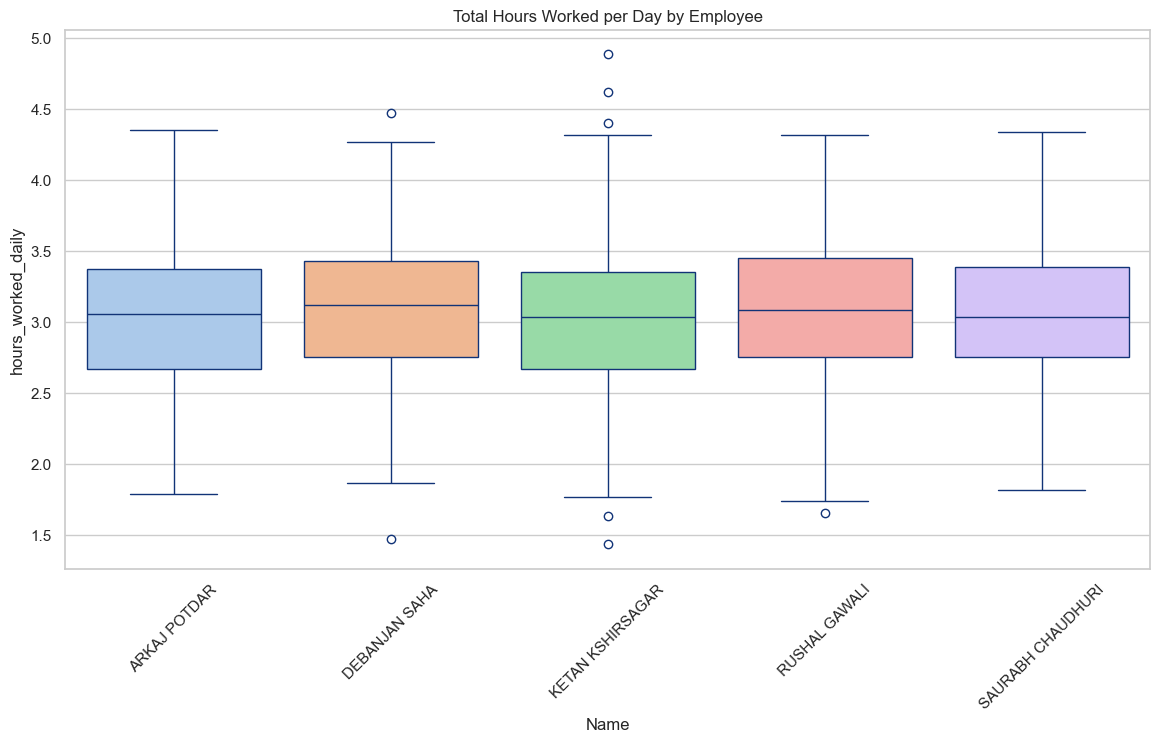

In [231]:
# Plot total hours worked per day for each employee
plt.figure(figsize=(14, 7))
sns.boxplot(x='Name', y='hours_worked_daily', data=daily_hours, hue='Name', linecolor="#137", palette='pastel')
plt.title('Total Hours Worked per Day by Employee')
plt.xticks(rotation=45)
plt.show()


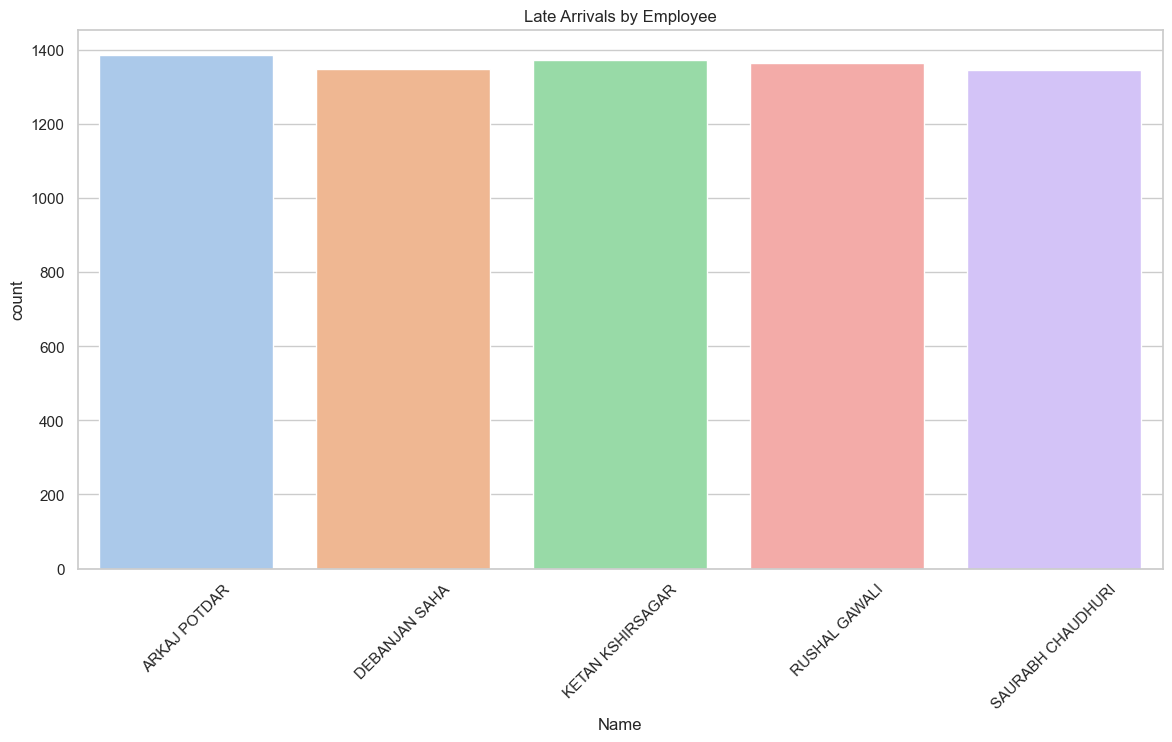

In [232]:
# Plot late arrivals
late_arrivals = df[df['late_arrival']]
plt.figure(figsize=(14, 7))
sns.countplot(x='Name', data=late_arrivals, hue='Name', palette='pastel')
plt.title('Late Arrivals by Employee')
plt.xticks(rotation=45)
plt.show()

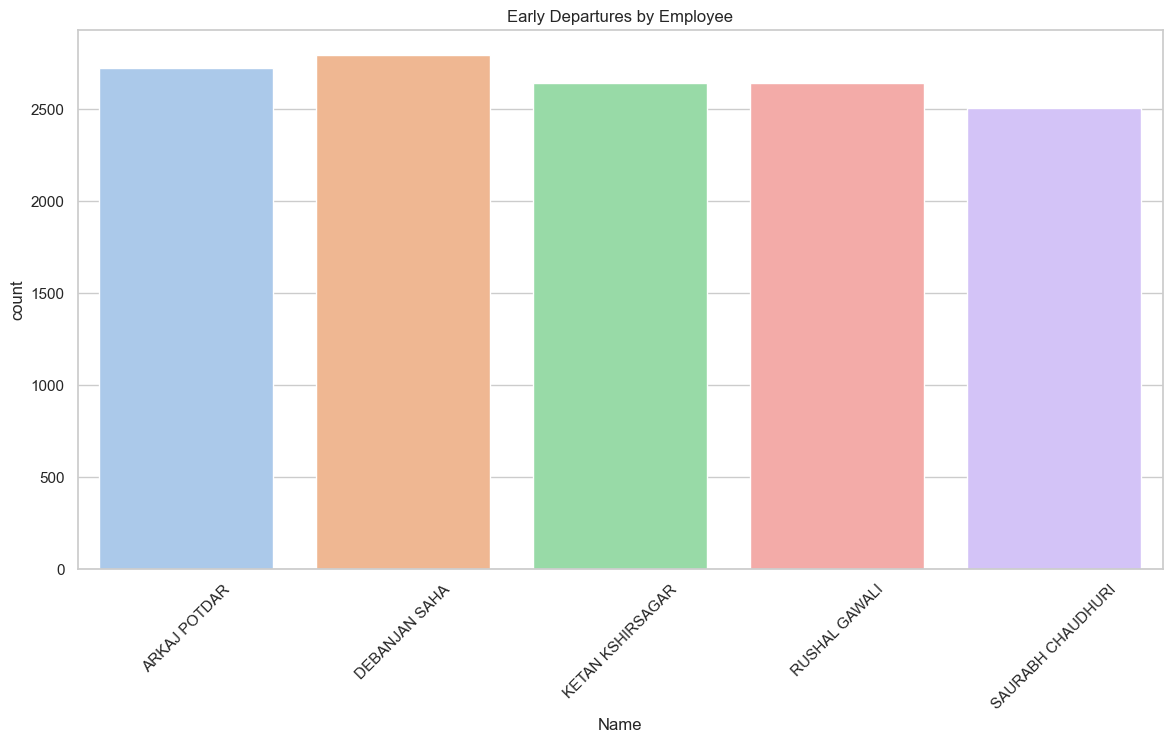

In [233]:
# Plot early departures
early_departures = df[df['early_departure']]
plt.figure(figsize=(14, 7))
sns.countplot(x='Name', data=early_departures, hue='Name', palette='pastel')
plt.title('Early Departures by Employee')
plt.xticks(rotation=45)
plt.show()

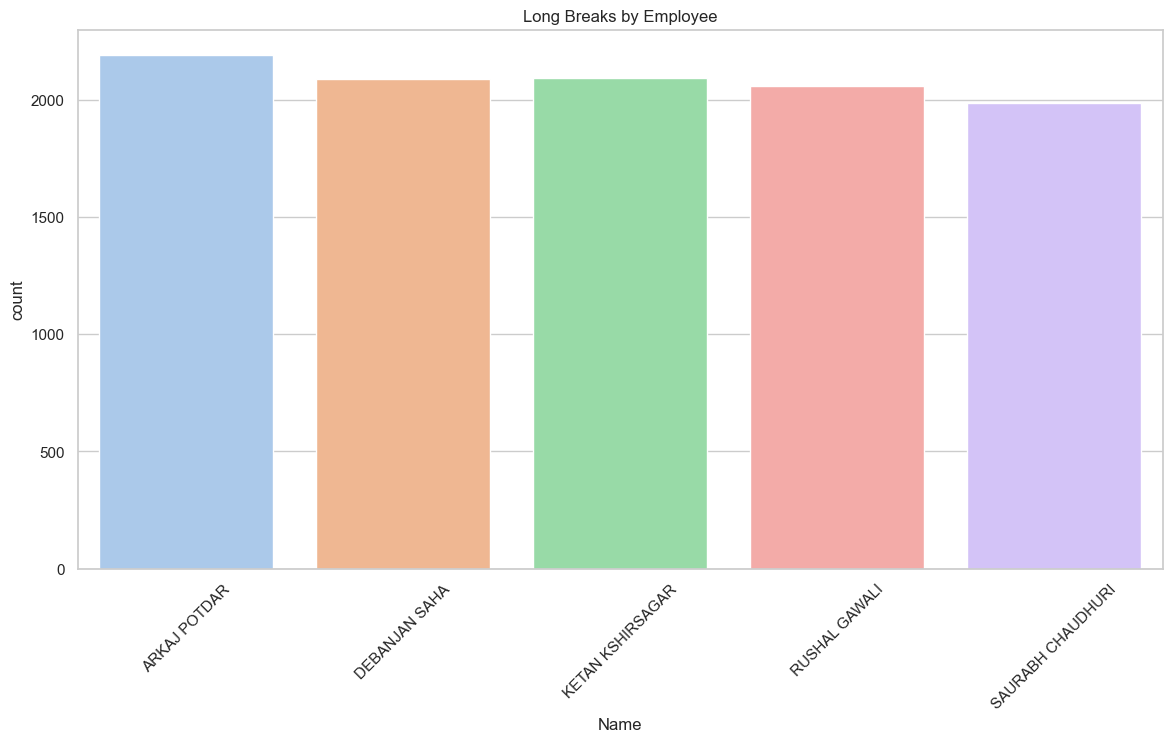

In [234]:
# Plot long breaks
long_breaks = breaks[breaks['long_break']]
plt.figure(figsize=(14, 7))
sns.countplot(x='Name', data=long_breaks, hue='Name', palette='pastel')
plt.title('Long Breaks by Employee')
plt.xticks(rotation=45)
plt.show()


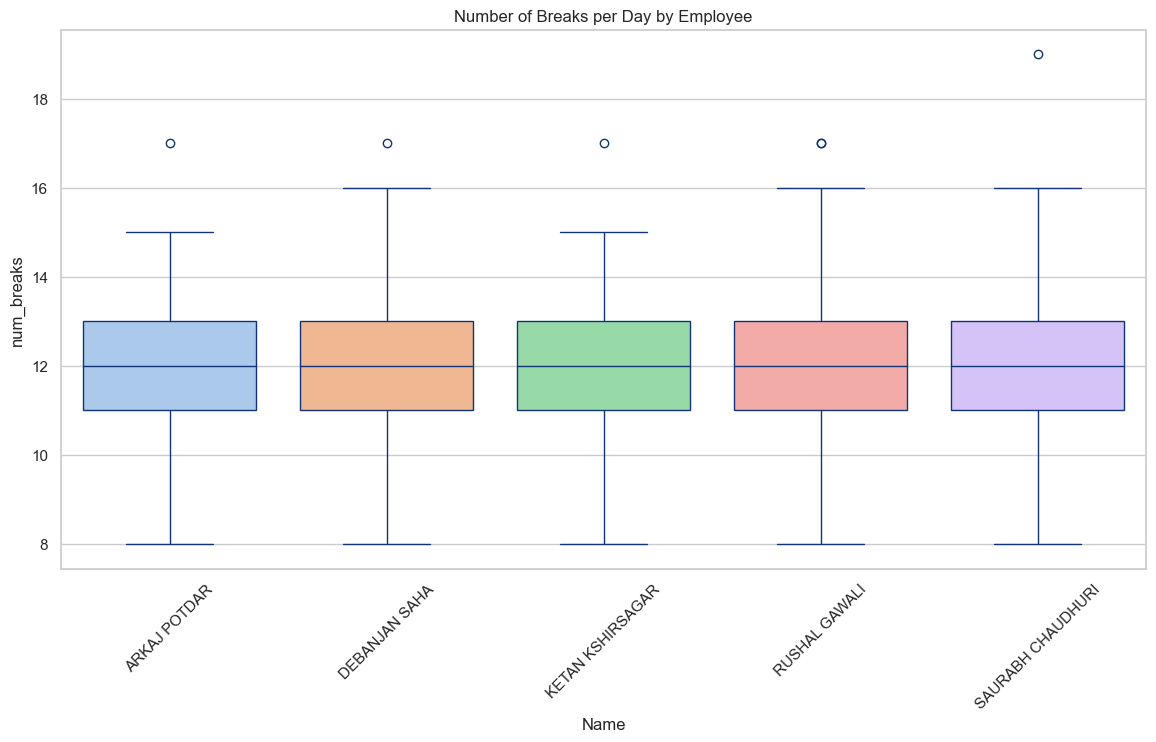

In [235]:
# Plot number of breaks per day
plt.figure(figsize=(14, 7))
sns.boxplot(x='Name', y='num_breaks', data=daily_breaks, hue='Name', linecolor="#137", palette='pastel')
plt.title('Number of Breaks per Day by Employee')
plt.xticks(rotation=45)
plt.show()

## Statistical Tests

### Late Arrivals Test

- **Null Hypothesis (H0)**: There is no significant difference in the number of late arrivals across employees.
- **Alternative Hypothesis (H1)**: There is a significant difference in the number of late arrivals across employees.


In [236]:
late_arrivals_count = df.groupby('Name')['late_arrival'].sum()
late_arrivals_mean = late_arrivals_count.mean()
late_arrivals_std = late_arrivals_count.std()

print(f"Late Arrivals Mean: {late_arrivals_mean}")
print(f"Late Arrivals Std Dev: {late_arrivals_std}")

Late Arrivals Mean: 1363.4
Late Arrivals Std Dev: 16.637307474468336


In [237]:
# ANOVA test for late arrivals
anova_result = stats.f_oneway(*[group['late_arrival'].values for name, group in df.groupby('Name')])
print(f"ANOVA test for Late Arrivals: F-statistic={anova_result.statistic}, p-value={anova_result.pvalue}")

ANOVA test for Late Arrivals: F-statistic=1.406156052388332, p-value=0.2290338256976814


**Interpretation**: The p-value is greater than the common significance level of 0.05. This suggests that we fail to reject the null hypothesis, meaning there is no significant difference in the number of late arrivals across employees.

### Early Departures Test

- **Null Hypothesis (H0)**: There is no significant difference in the number of early departures across employees.
- **Alternative Hypothesis (H1)**: There is a significant difference in the number of early departures across employees.


In [238]:
early_departures_count = df.groupby('Name')['early_departure'].sum()
early_departures_mean = early_departures_count.mean()
early_departures_std = early_departures_count.std()

print(f"Early Departures Mean: {early_departures_mean}")
print(f"Early Departures Std Dev: {early_departures_std}")


Early Departures Mean: 2659.2
Early Departures Std Dev: 107.77151757305823


In [239]:
# ANOVA test for early departures
anova_result = stats.f_oneway(*[group['early_departure'].values for name, group in df.groupby('Name')])
print(f"ANOVA test for Early Departures: F-statistic={anova_result.statistic}, p-value={anova_result.pvalue}")

ANOVA test for Early Departures: F-statistic=2.2497474400528454, p-value=0.061164679260653644


**Interpretation**: The p-value is greater than the common significance level of 0.05. This suggests that we fail to reject the null hypothesis, meaning there is no significant difference in the number of early departures across employees.

### Long Breaks Test

- **Null Hypothesis (H0)**: There is no significant difference in the number of long breaks across employees.
- **Alternative Hypothesis (H1)**: There is a significant difference in the number of long breaks across employees.


In [240]:
long_breaks_count = breaks.groupby('Name')['long_break'].sum()
long_breaks_mean = long_breaks_count.mean()
long_breaks_std = long_breaks_count.std()

print(f"Long Breaks Mean: {long_breaks_mean}")
print(f"Long Breaks Std Dev: {long_breaks_std}")

Long Breaks Mean: 2082.4
Long Breaks Std Dev: 72.52103143226797


In [241]:
# ANOVA test for long breaks
anova_result = stats.f_oneway(*[group['long_break'].values for name, group in breaks.groupby('Name')])
print(f"ANOVA test for Long Breaks: F-statistic={anova_result.statistic}, p-value={anova_result.pvalue}")

ANOVA test for Long Breaks: F-statistic=1.2278066176076146, p-value=0.2965663069598872


**Interpretation**: The p-value is greater than the common significance level of 0.05. This suggests that we fail to reject the null hypothesis, meaning there is no significant difference in the number of long breaks across employees.

### Normality test for total hours worked   
   - **Null Hypothesis (H0)**: The total hours worked per day is normally distributed.
   - **Alternative Hypothesis (H1)**: The total hours worked per day is not normally distributed.

In [242]:

hours_worked_daily = df['hours_worked_daily']
k2, p = stats.normaltest(hours_worked_daily)
print(f"Normality test for Total Hours Worked: statistic={k2}, p-value={p}")

Normality test for Total Hours Worked: statistic=39.64221858120392, p-value=2.464913082797164e-09


**Interpretation**: The p-value is much smaller than 0.05, indicating that we reject the null hypothesis. This suggests that the distribution of total hours worked per day is not normally distributed.

### Average Hours Worked:

- **Null Hypothesis (H0)**: The average hours worked per day are the same across all employees.
- **Alternative Hypothesis (H1)**: The average hours worked per day differ among employees.

In [243]:
# ANOVA test for average hours worked
anova_hours = stats.f_oneway(*[group['hours_worked_daily'].values for name, group in df.groupby('Name')])
print(f"ANOVA test for Average Hours Worked: F-statistic={anova_hours.statistic}, p-value={anova_hours.pvalue}")

ANOVA test for Average Hours Worked: F-statistic=21.47764602026209, p-value=1.0627916427612237e-17


**Interpretation**: The p-value is much smaller than 0.05, indicating that we reject the null hypothesis. This suggests that the average hours worked per day is not the same across all employees.

### Correlation Between Breaks and Productivity:

- **Null Hypothesis (H0)**: There is no correlation between the number of breaks taken and the total hours worked.
- **Alternative Hypothesis (H1)**: There is a correlation between the number of breaks taken and the total hours worked.

In [244]:
# Pearson correlation coefficient
correlation, p_value = stats.pearsonr(df['num_breaks'], df['hours_worked_daily'])
print(f"Pearson Correlation between Number of Breaks and Hours Worked: correlation={correlation}, p-value={p_value}")

Pearson Correlation between Number of Breaks and Hours Worked: correlation=0.3053740218226593, p-value=0.0


**Interpretation**: The Pearson correlation coefficient of 0.305 indicates a weak positive correlation between the number of breaks taken and the total hours worked. The p-value of 0.0 (which is less than 0.05) suggests that this correlation is statistically significant. This means that as the number of breaks increases, the total hours worked also tend to increase slightly.

### Shapiro-Wilk Test for Arrival Times Normality

- **Null Hypothesis (H0)**: The distribution of arrival times follows a normal distribution.
- **Alternative Hypothesis (H1)**: The distribution of arrival times does not follow a normal distribution.

In [245]:
arrival_times = df['first_in'].dropna().apply(lambda x: x.time())
arrival_seconds = arrival_times.apply(lambda t: t.hour*3600 + t.minute*60 + t.second)

# Shapiro-Wilk test for normality
shapiro_test = stats.shapiro(arrival_seconds)
print(f"Shapiro-Wilk test for Arrival Times: W-statistic={shapiro_test.statistic}, p-value={shapiro_test.pvalue}")


Shapiro-Wilk test for Arrival Times: W-statistic=0.96125679197176, p-value=3.7659224532465346e-57


/Users/debanjansaha/.pyenv/versions/3.10.13/envs/vision/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 19720.
  res = hypotest_fun_out(*samples, **kwds)


**Interpretation**: The p-value is much smaller than 0.05, indicating that we reject the null hypothesis. This suggests that the distribution of arrival times does not follow a normal distribution. The arrival times of employees are not normally distributed, which could imply that there are specific patterns or clusters in how employees arrive at work.

### Paired T-Test for Late Arrivals and Early Departures

- **Null Hypothesis (H0)**: The mean number of late arrivals is equal to the mean number of early departures.
- **Alternative Hypothesis (H1)**: The mean number of late arrivals is different from the mean number of early departures.

In [246]:
# Calculate the mean number of late arrivals and early departures for each employee
late_arrivals_mean = df.groupby('Name')['late_arrival'].mean()
early_departures_mean = df.groupby('Name')['early_departure'].mean()

# Paired t-test
t_stat, p_value = stats.ttest_rel(late_arrivals_mean, early_departures_mean)
print(f"Paired T-test for Late Arrivals and Early Departures: t-statistic={t_stat}, p-value={p_value}")


Paired T-test for Late Arrivals and Early Departures: t-statistic=-40.083944269129056, p-value=2.3145662112679387e-06


**Interpretation**: The p-value is much smaller than 0.05, indicating that we reject the null hypothesis. This means that there is a significant difference between the mean number of late arrivals and early departures. Given the negative t-statistic, it suggests that the mean number of late arrivals is significantly lower than the mean number of early departures.

## Modeling

In [247]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19720 entries, 0 to 19719
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype              
---  ------                --------------  -----              
 0   Name                  19720 non-null  object             
 1   session_id            19720 non-null  int64              
 2   first_in              19720 non-null  datetime64[ns, UTC]
 3   last_out              19720 non-null  datetime64[ns, UTC]
 4   hours_worked          19720 non-null  float64            
 5   date                  19720 non-null  object             
 6   first_in_daily_first  19720 non-null  datetime64[ns, UTC]
 7   last_out_daily_last   19720 non-null  datetime64[ns, UTC]
 8   late_arrival          19720 non-null  bool               
 9   early_departure       19720 non-null  bool               
 10  long_break            19720 non-null  bool               
 11  hours_worked_daily    19720 non-null  float64            
 12  num_

In [248]:
features = ['late_arrival', 'early_departure', 'long_break', 'num_breaks']
X = df[features]
y = df['hours_worked_daily']

In [249]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [250]:
# Train a Random Forest model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [251]:
# Predict on the test set
y_pred = model.predict(X_test)

In [252]:
# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

Mean Squared Error: 0.1992874264994646
R-squared: 0.13401442860012192


## Visualization and Reporting

### Feature importance

In [253]:
importance = model.feature_importances_
feature_names = X.columns
feature_importance = pd.DataFrame({'feature': feature_names, 'importance': importance}).sort_values(by='importance', ascending=False)


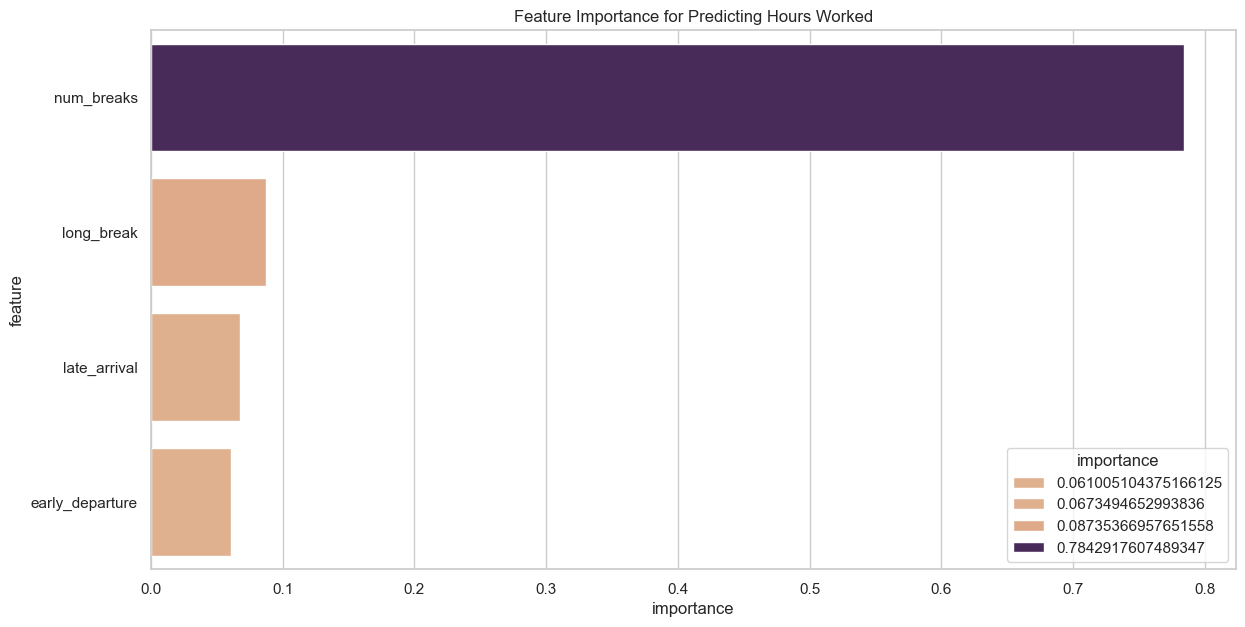

In [254]:
# Plot feature importance
plt.figure(figsize=(14, 7))
sns.barplot(x='importance', y='feature', data=feature_importance, hue='importance', palette='flare')
plt.title('Feature Importance for Predicting Hours Worked')
plt.show()

In [255]:
# Summary report
summary_report = df.groupby('Name').agg(
    total_hours_worked=('hours_worked_daily', 'sum'),
    average_hours_worked=('hours_worked_daily', 'mean'),
    late_arrivals=('late_arrival', 'sum'),
    early_departures=('early_departure', 'sum'),
    long_breaks=('long_break', 'sum'),
    total_breaks=('num_breaks', 'sum')
).reset_index()

# Display the summary report
print(summary_report)

                Name  total_hours_worked  average_hours_worked  late_arrivals  \
0       ARKAJ POTDAR        12397.900000              3.050664           1385   
1      DEBANJAN SAHA        12528.533333              3.111906           1349   
2   KETAN KSHIRSAGAR        11919.450000              3.041452           1373   
3      RUSHAL GAWALI        12358.200000              3.119970           1365   
4  SAURABH CHAUDHURI        11563.916667              3.083711           1345   

   early_departures  long_breaks  total_breaks  
0              2722         2189         48818  
1              2791         2086         49155  
2              2642         2090         47310  
3              2638         2060         48286  
4              2503         1987         45381  
